# Convolutional approach

The idea is to treat the stock market data as "images" where the rows are dates, colums are stocks and the depth is features such as high/low or open/close. This way the network hopefully can learn inter-dependencies of the stocks and perhaps discover someuseful patterns. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import class_weight
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,SeparableConv2D
import os
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
def load_data(file_path):
    all_data = np.load(file_path)
    num_to_symbol = np.load(file_path.replace(".npy","_DIC.npy"))
    
    return all_data, num_to_symbol.tolist()

In [3]:
def to_label(prediction_data):
    #Shape of prediction_data is prediciton_size x n_features
   
    if np.all(prediction_data[:,2]>0): #if feature 1 is strictly increasing
        c = 0
        
    elif np.all(prediction_data[:,2] < 0): #if feature 1 is strictly decreasing
        c = 2
    else: 
        c=1 #if feature 1 is neither increasing or decreasing its class 1
        
    return c

In [4]:
# Chops up data into size chunks
def to_datapoints(all_data, chunk_size, prediction_size, prediction_symbol_index):
    
    n_entries, n_symbols, n_features = np.shape(all_data)
    
    n_datapoints = n_entries-chunk_size-prediction_size+1
    
    datapoints = np.zeros([n_datapoints,chunk_size,n_symbols,n_features])
    labels = np.zeros([n_datapoints])
    
    for i in range(n_datapoints):
        data_chunk = all_data[i:i+chunk_size,:,:]
        datapoints[i,:,:,:] = data_chunk
        
        prediction_data = all_data[i+chunk_size:i+chunk_size+prediction_size,prediction_symbol_index,:]
        labels[i] = to_label(prediction_data)
        
    return datapoints,labels

In [21]:
# An obvious misstake that needs correction below is that when dealing with 
#temporal data we can not randomly shuffle since we will train the network on data 
#that will "almost" appear in the test set. This solution will serve as a place-holder for now

def train_test_split(datapoints, labels, fraction = 0.8, shuffle = False):
    
    data = datapoints.copy()
    
    
    n_testpoints = int(fraction*np.shape(datapoints)[0])
    
    if(shuffle):
        n_datapoints = np.shape(data)[0]
        permutation = np.random.permutation(np.arange(n_datapoints))
        
        data = datapoints[permutation,:,:,:]
        
    x_train = data[:n_testpoints,:,:,:]
    x_test = data[n_testpoints:,:,:,:]
    y_train = labels[:n_testpoints]
    y_test = labels[n_testpoints:]
    
    return x_train,y_train, x_test, y_test

In [6]:
file_path = "processed_data/aligned_dates/all_data_with_aligned_dates_changes.npy"
all_data, sym_to_num = load_data(file_path)
num_to_sym = {value : key for (key,value) in sym_to_num.items()}

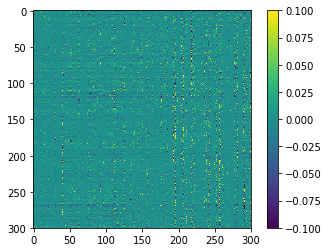

In [7]:
plt.imshow(all_data[1000:1300,:300,0])
plt.colorbar()
plt.clim(-0.1,0.1)

Not so useful image for humans, hopefully we can make a neural network that can interpret it better.

In [8]:
np.shape(all_data)

(4718, 377, 8)

## Sort out newly noted stocks

We only want to consider stocks that have a decent amount of history, in this case more than 3000 entries, as to avoid stocks which only recently was introduced to the market. 

In [9]:
tmp = np.shape(all_data)[0]-np.sum(all_data[:,:,0] == 0,axis=0)>3000
chosen_stocks = np.argwhere(tmp).flatten()
chosen_data = all_data[:3000,chosen_stocks,:]

In [10]:
stocks = [num_to_sym[x] for x in chosen_stocks]
print(stocks)

['AAK', 'ABB', 'AF-B', 'ALFA', 'ALIV-SDB', 'ASSA-B', 'ATCO-A', 'ATCO-B', 'ATRLJ-B', 'AXFO', 'AXIS', 'AZA', 'AZN', 'BALD-B', 'BILL', 'BOL', 'CAST', 'EKTA-B', 'ELUX-A', 'ELUX-B', 'ERIC-A', 'ERIC-B', 'FABG', 'FING-B', 'GETI-B', 'HEXA-B', 'HM-B', 'HOLM-A', 'HOLM-B', 'HPOL-B', 'HUFV-A', 'HUSQ-A', 'HUSQ-B', 'INDT', 'INDU-A', 'INDU-C', 'INTRUM', 'INVE-A', 'INVE-B', 'JM', 'KINV-A', 'KINV-B', 'KLED', 'KLOV-A', 'LATO-B', 'LUND-B', 'LUPE', 'MIC-SDB', 'MTG-A', 'MTG-B', 'NCC-A', 'NCC-B', 'NDA-SEK', 'NIBE-B', 'NOBI', 'ORI', 'PEAB-B', 'RATO-A', 'RATO-B', 'SAAB-B', 'SAGA-A', 'SAND', 'SCA-A', 'SCA-B', 'SEB-A', 'SEB-C', 'SECU-B', 'SHB-A', 'SHB-B', 'SKA-B', 'SKF-A', 'SKF-B', 'SSAB-A', 'SSAB-B', 'STE-A', 'STE-R', 'SWEC-B', 'SWED-A', 'SWMA', 'TEL2-A', 'TEL2-B', 'TELIA', 'TIETOS', 'TREL-B', 'VOLV-A', 'VOLV-B', 'WALL-B', 'WIHL', 'ACAN-B', 'ADDT-B', 'ANOD-B', 'AQ', 'BEIA-B', 'BEIJ-B', 'BERG-B', 'BILI-A', 'BIOG-B', 'BIOT', 'BURE', 'CAT-A', 'CAT-B', 'CATE', 'CLA-B', 'CLAS-B', 'ELAN-B', 'ENQ', 'FAG', 'FPAR', 'GU

In [11]:
np.shape(chosen_data)

(3000, 182, 8)

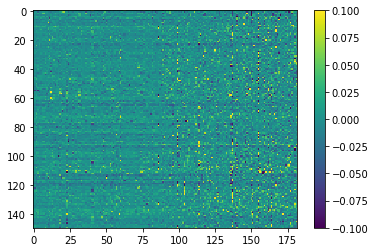

In [16]:
plt.imshow(chosen_data[1000:1150,:,0])
plt.colorbar()
plt.clim(-0.1,0.1)

Interestingly we can se some sort of wave pattern along the temporal axis, this might do well for some time series investigation to extract seasonality. 

## Chop up into training data

To make training data of this we chop it up into chunks of <chunk_size> dates. These will then serve as the input data and the labels will be wether the stock has monotonically increased or decreased during the <prediciton_size> entries following the data point.

In [22]:
#Normalize volume
chosen_data[:,:,5] = chosen_data[:,:,5] / np.max(chosen_data[:,:,5],axis=0)

In [23]:
chunk_size = 10
prediction_size = 3
symbol_index = 10
datapoints, labels = to_datapoints(chosen_data[:,:,[1,2,3]],chunk_size,prediction_size,symbol_index)
print("Symbol is {}".format(num_to_sym[symbol_index]))

Symbol is ATCO-A


In [24]:
np.shape(datapoints)

(2988, 10, 182, 3)

In [25]:
count = np.bincount(labels.astype(np.uint8))
print("Class distribution is {}/{}/{} ".format(count[0],count[1],count[2]))

Class distribution is 256/2472/260 


# Start training CNN

In [26]:
x_train,y_train, x_test, y_test = train_test_split(datapoints, labels, shuffle = False)

In [27]:
train_count = np.bincount(y_train.astype(np.uint8))
train_s = np.sum(train_count)
print("Training class distribution is {:.3f}/{:.3f}/{:.3f} ".format(train_count[0]/train_s,train_count[1]/train_s,train_count[2]/train_s))
test_count = np.bincount(y_test.astype(np.uint8))
test_s = np.sum(test_count)
print("Test class distribution is {:.3f}/{:.3f}/{:.3f} ".format(test_count[0]/test_s,test_count[1]/test_s,test_count[2]/test_s))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Training class distribution is 0.079/0.838/0.082 
Test class distribution is 0.110/0.783/0.107 
x_train shape: (2390, 10, 182, 3)
2390 train samples
598 test samples


Since we have a rather uneven distriution of classes we neet to compensate for this using the keras "class_weight" feature. 

In [32]:
cw = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

In [33]:
batch_size = 16
num_classes = 3
epochs = 20

In [34]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [35]:
model = None
model = Sequential()

model.add(Conv2D(16, (3, 3),input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(8, (3, 3)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
#model.add(Dense(64))
#model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [36]:
opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[keras.metrics.categorical_accuracy])

In [42]:
# Perform some normalization using keras built in functions
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True) 
datagen.fit(x_train)

In [43]:
history = model.fit_generator(datagen.flow(x_train,y_train,batch_size = batch_size),
                              epochs=epochs,
                              validation_data=(x_test,y_test),
                              class_weight =cw)

Epoch 1/20
150/150 [==============================] - 7s 45ms/step - loss: 0.5848 - categorical_accuracy: 0.8392 - val_loss: 0.7771 - val_categorical_accuracy: 0.7692
Epoch 2/20
150/150 [==============================] - 8s 52ms/step - loss: 0.5904 - categorical_accuracy: 0.8385 - val_loss: 0.8180 - val_categorical_accuracy: 0.7726
Epoch 3/20
150/150 [==============================] - 7s 46ms/step - loss: 0.5883 - categorical_accuracy: 0.8392 - val_loss: 0.9371 - val_categorical_accuracy: 0.7759
Epoch 4/20
150/150 [==============================] - 7s 47ms/step - loss: 0.5826 - categorical_accuracy: 0.8385 - val_loss: 0.9545 - val_categorical_accuracy: 0.7492
Epoch 5/20
150/150 [==============================] - 9s 61ms/step - loss: 0.5820 - categorical_accuracy: 0.8387 - val_loss: 0.7997 - val_categorical_accuracy: 0.7826
Epoch 6/20
150/150 [==============================] - 8s 52ms/step - loss: 0.5893 - categorical_accuracy: 0.8378 - val_loss: 0.7798 - val_categorical_accuracy: 0.789

In [44]:
model.evaluate_generator(datagen.flow(x_test,y_test,batch_size=1))

[0.77428633045719741, 0.78260869565217395]

In [45]:
print(history.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


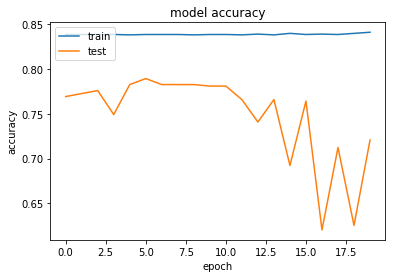

In [46]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
output = model.predict_generator(datagen.flow(x_test))
y_pred = np.argmax(output,axis = 1)
y_true = np.argmax(y_test,axis = 1)

In [48]:
cm = confusion_matrix(y_true,y_pred)

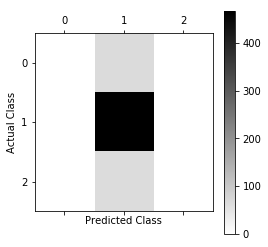

Accuracy: {} 0.782608695652


In [49]:
img = plt.matshow(cm,cmap="binary")
plt.colorbar()
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()
print("Accuracy: {}", np.sum(np.diag(cm))/np.shape(y_true)[0])



As expected the network doesnt perform well for a myriad of reasons that needs adressing, for now it classifies everything as class 1, which happens to be the most frequent class. 